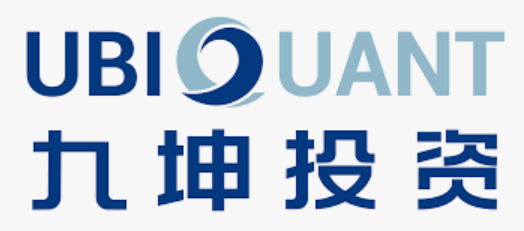

- v1 first release with CVXPY portfolio optimization style neutralization
- v2 add CV; added simple linear offset neutralization; added soft constraint neutralization

# Feature Neutralization

@marketneutral

<div class="alert alert-warning">
<b>TL;DR:</b> We post process the model predictions to remove all linear exposure to the 300 input features. This approach has been sucessful in helping model to generalize in other financial prediction contexts, specifically the Numerai competition. This is a work in progress.
</div>

# Install CVXPY from Dataset

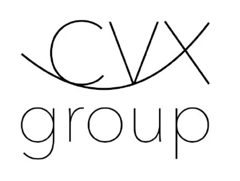

The `cvxpy` package is not in the Kaggle Dockerfile. This is a famous package for convex optimization with over 3,800 GitHub stars. Since this is a code competition, we cannot pip install it from PyPI. I created a "dataset" with the package [here](https://www.kaggle.com/marketneutral/cvxpy-python-package); it is attached to this notebook and we need to install all the individual Python wheels. Thanks [Chris Deotte](https://www.kaggle.com/cdeotte) for guidance on [how to do this](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/113195).

In [ ]:
%%capture

! pip install ../input/cvxpy-python-package/qdldl-0.1.5.post0-cp37-cp37m-manylinux2014_x86_64.whl
! pip install ../input/cvxpy-python-package/scs-3.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
! pip install ../input/cvxpy-python-package/scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
! pip install ../input/cvxpy-python-package/osqp-0.6.2.post5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
! pip install ../input/cvxpy-python-package/numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
! pip install ../input/cvxpy-python-package/ecos-2.0.10-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl
! pip install ../input/cvxpy-python-package/cvxpy-1.1.18-cp37-cp37m-manylinux_2_24_x86_64.whl

In [ ]:
import gc, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import cvxpy as cvx
import lightgbm as lgb

from tqdm.notebook import tqdm
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

plt.rcParams['figure.figsize'] = (16, 5)

import warnings
warnings.filterwarnings("ignore")

# Load and Inspect the Data

Thanks [Rob Mulla](https://www.kaggle.com/robikscube) for the reduced memory version of the data.

In [ ]:
%%time
train = (pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
         .sort_values(['time_id', 'investment_id'])
         .drop(columns=['row_id'])
         .query('time_id > 599')
         .reset_index(drop=True));

gc.collect()

In [ ]:
all_columns = train.columns
features = all_columns[train.columns.str.contains('f_')]

In [ ]:
train.shape

In [ ]:
train.head()

The CV scheme, `PurgedGroupTimeSeriesSplit` is from my notebook ["Purged Time Series CV, XGBoost, Optuna"](https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna). You can read details of this CV scheme there.

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

# Train LGB and Inspect Feature Importance

This is a helper function which trains each fold, keeps track of feature importance, and plots feature importance (with error bars).

In [ ]:
# based on source https://www.kaggle.com/artgor/dota-eda-fe-and-models

def train_model(
    X,
    y,
    params,
    cv,
    score_func,
    plot_feature_importance=False,
    cat_features=[],
    importance_type='gain',
    groups=None,
    clip=True,
    clip_bounds=(-15,15)
):

    oof = []
    scores = []
    feature_importance = pd.DataFrame()
    models = []
    
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X, groups=groups)):
        print('Fold', fold_n+1, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if clip:
            X_train = X_train.clip(clip_bounds[0], clip_bounds[1])
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)

        model = lgb.train(
            params=params,
            train_set=train_data,
            num_boost_round=2000,
            valid_sets=[
                train_data,
                valid_data
            ],
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=200)
            ],
            categorical_feature = \
                cat_features if len(cat_features) > 0 else 'auto'
        )
        
        models.append(model)

        y_pred_valid = model.predict(X_valid)

        oof.append(pd.DataFrame(index=valid_index, data=y_pred_valid.reshape(-1,), columns=['pred']))
        scores.append(score_func(y_valid, y_pred_valid))

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importance(importance_type)
        fold_importance["fold"] = fold_n + 1
        feature_importance = \
            pd.concat([feature_importance, fold_importance], axis=0)

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores),
                                                         np.std(scores)))
    
    feature_importance["importance"] /= (fold_n + 1)

    if plot_feature_importance:
        cols = (feature_importance[["feature", "importance"]]
                  .groupby("feature")
                  .mean()
                  .sort_values(by="importance", ascending=False)[:50].index)

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 10));
        sns.barplot(
            x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False));
        plt.title(f'LGBM Feature Importances (avgerage over folds): {importance_type}');
        
        return oof, scores, feature_importance, models
    else:
        return oof, scores, models


In [ ]:
params = {
    'feature_fraction': 0.85,   # change to col_sample_by_level
    'bagging_fraction': 0.85,
    'learning_rate': 0.05,
    'max_depth': -1,
    'min_data_in_leaf': 500,
    'num_threads': -1,
    'verbosity': -1,
    'objective': "regression"
}

In [ ]:
tscv = PurgedGroupTimeSeriesSplit(
    n_splits=3,
    max_train_group_size=120,
    group_gap=10,
    max_test_group_size=40
)

# Baseline LGB

In [ ]:
%%time
oof, scores, feature_imp, lgb_models = train_model(
    train.dropna()[features].reset_index(drop=True),
    train.dropna()['target'].reset_index(drop=True),
    params=params,
    cv=tscv,
    plot_feature_importance=True,
    score_func=mean_squared_error,
    groups=train.dropna().reset_index(drop=True)['time_id']
)

In [ ]:
scores

In [ ]:
np.mean(scores), np.std(scores)

In [ ]:
oof[0].plot()

# Feature Neutralization

In portfolio management, it is typical that a portfolio is contrained to have a certain exposure, typically zero exposure, to a set a predefined risk factors. The reason for this stems from both theory (i.e., to maximize breadth vis a vis the Fundamental Theorem of Active Management, you want your bets to be minimally correlated) and practice (i.e., investors should not pay you to give them exposures to things they can easily get on their own). One research development coming from the Numerai forums and competition, is that it can also be beneficial to maintain low to zero linear exposure to all of the features in the design matrix. One conjecture as to why this is beneficial is that positive expected value linear features are (more) easily discovered by competitive market participants and therefore do not persist long out-of-sample (they are arbitraged away). The conditional features (found via a non-linear model like LGB) are more difficult for an investor to uncover. In this section we test the fold predictions from above *after* removing or reducing linear exposure to the features. We look at three ways of doing this

In [ ]:
def post_process_cross_val_score(
    oof_preds,
    y_ground_truth,
    train,
    feature_names,
    scorer,
    func,
    **kwargs
):

    grouped = oof_preds.groupby('time_id')
    w_fold = []

    for i, (name, group) in tqdm(enumerate(grouped), total=len(grouped)):
        idx = train.query('time_id==@name')[feature_names].index
        factor_loadings = train.query('time_id==@name')[feature_names].values
        preds = group['pred']
        
        try:
            targets = y_ground_truth[idx]
            w = func(preds, factor_loadings, **kwargs)
            
            w_fold.append(pd.DataFrame(
                index = idx,
                data=(w if type(w) == np.ndarray else w.values),
                columns=['preds_neutralized'])
            )
        except:
            print(f'Failed for day {name}')
            w_fold.append(pd.DataFrame(
                index = preds.index,
                data = preds.values,
                columns=['preds_neutralized'])
            )

    adj_oof = pd.concat(w_fold)
    
    return adj_oof, scorer(adj_oof['preds_neutralized'].values, y_ground_truth)



## 1. Linear Model Offset

In this method, we simply estimate a linear model at each time step and subtract off the predictions. The financial intution is that the LGB model gives us linear + non-linear exposures; when we subtract off the linear predictions, we are left with just the non-linear exposures. Given a daily prediction vector $z$, find the adjusted vector $w$.

$$w = z - \gamma \times \text{linear prediction}$$

where $0 < \gamma \leq 1$. 




In [ ]:
def neutralize_day__offset(preds, features, model_cls, gamma=0.33, fit_params={}):
    model = model_cls(**fit_params)
    model.fit(features, preds)
    model_preds = model.predict(features)
    
    if (~np.isfinite(model_preds)).any():
        print('Linear offset failed; making no adjustment for this day.')
        return preds
    else:
        return preds - gamma*model_preds

In [ ]:
adj_scores_linear = []
adj_oofs_linear = []

for fold in tqdm(oof):
    oof_ = fold.copy()
    oof_['time_id'] = train['time_id']
    oof_['target'] = train['target']
    
    tmp_oof, tmp_score = post_process_cross_val_score(
        oof_,
        oof_['target'],
        train,
        features,
        mean_squared_error,
        neutralize_day__offset,
        model_cls=Ridge,
        gamma=0.33,
        fit_params={'alpha': 0.01}
    )
    
    adj_scores_linear.append(tmp_score)
    adj_oofs_linear.append(tmp_oof)

In [ ]:
np.mean(adj_scores_linear), np.std(adj_scores_linear)


## 2. Optimization with Hard Constraint

In this method we solve a convex optimization problem *per time_id*: given a daily prediction vector $z$, find the adjusted vector $w$, such that the linear exposure to every feature is zero. The feature matrix is $F$.

\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimize}}
& & \lVert w - z \rVert_2^2 \\
& \text{subject to}
& & \text{mean}(w) = \text{mean}(z) \\
&&& F'w = 0 \\
\end{aligned}
\end{equation*}


In [ ]:
def mean(x):
    return cvx.sum(x) / x.size

In [ ]:
def neutralize_day__hard(preds, features, **kwargs):
    """Given an n length vector of predictions for a time step and a
    n x m matrix of features, calculate, via optimization, the prediction
    vector nearest to the one provided, but with zero linear exposure
    to the features."""
    
    n = len(preds)
    w = cvx.Variable(n)
    
    Fw = features.T @ w
    
    obj = cvx.Minimize(
      cvx.sum_squares(w - preds)
    )
    
    constraints = [
        Fw == 0,
        mean(w) == mean(preds)
    ]
    
    prob = cvx.Problem(obj, constraints)
    prob.solve(verbose=False)
    
    return np.asarray(w.value).flatten()

In [ ]:
adj_scores_hard = []
adj_oofs_hard = []

for fold in tqdm(oof):
    oof_ = fold.copy()
    oof_['time_id'] = train['time_id']
    oof_['target'] = train['target']
    
    tmp_oof, tmp_score = post_process_cross_val_score(
        oof_,
        oof_['target'],
        train,
        features,
        mean_squared_error,
        neutralize_day__hard
    )
    
    adj_scores_hard.append(tmp_score)
    adj_oofs_hard.append(tmp_oof)

In [ ]:
np.mean(adj_scores_hard), np.std(adj_scores_hard)


## 3. Optimization with Soft Constraint

In this method we move the neutralization constraint up to the objective function. Again, given a daily prediction vector $z$, find the adjusted vector $w$.

\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimize}}
& & \lVert w - z \rVert_2^2 + \gamma \lVert F'w \rVert_2^2 \\
& \text{subject to}
& & \text{mean}(w) = \text{mean}(z) \\
\end{aligned}
\end{equation*}

Here $\gamma$ is an additional hyperparameter. The higher the value of $\gamma$ the more the optimization will push the linear exposures to zero.

In [ ]:
def neutralize_day__soft(preds, features, gamma=0.001):
    
    n = len(preds)
    w = cvx.Variable(n)
    
    Fw = features.T @ w
    
    obj = cvx.Minimize(
      cvx.sum_squares(w - preds) + gamma*cvx.sum_squares(Fw)
    )
    
    constraints = [
        mean(w) == mean(preds)
    ]
    
    prob = cvx.Problem(obj, constraints)
    prob.solve(verbose=False)
    
    return np.asarray(w.value).flatten()

In [ ]:
adj_scores_soft = []
adj_oofs_soft = []

for fold in tqdm(oof):
    oof_ = fold.copy()
    oof_['time_id'] = train['time_id']
    oof_['target'] = train['target']
    
    tmp_oof, tmp_score = post_process_cross_val_score(
        oof_,
        oof_['target'],
        train,
        features,
        mean_squared_error,
        neutralize_day__soft,
        gamma=0.001
    )
    
    adj_scores_soft.append(tmp_score)
    adj_oofs_soft.append(tmp_oof)

In [ ]:
np.mean(adj_scores_soft), np.std(adj_scores_soft)

# Prediction Time!

In [ ]:
%%time

import ubiquant

env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission


for (test_df, sample_prediction_df) in iter_test:
    test_df['target'] = 0
    for i, mod in enumerate(lgb_models): 
        test_df['target'] += mod.predict(test_df[features])
    test_df['target'] /= len(lgb_models)

    nt = neutralize_day__offset(
        test_df['target'].values,
        test_df[features].values,
        model_cls=Ridge,
        gamma=0.33,
        fit_params={'alpha': 0.01}
    )
    
    test_df['target'] = nt

    env.predict(test_df[['row_id','target']])

Thank you for taking a look at this notebook. Please leave comments and suggestions.